<h1 style="background-color: #004466; color: #FFD700; text-align: center; padding: 20px; border-radius: 12px; box-shadow: 5px 5px 10px rgba(0, 0, 0, 0.3); font-family: Arial, sans-serif; letter-spacing: 2px;">
    Northwind Traders Capstone Project
</h1>

In [8]:
import psycopg2 as ps
import pandas as pd
import pandas.io.sql as sqlio
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
# import sqlalchemy as sqlio
import warnings
warnings.filterwarnings('ignore')

In [10]:
connection = ps.connect(dbname = "Kodlasam",
                        user = "postgres",
                        password = "12345",
                        port = "5432")

# 1-ÜRÜN SATIŞINA GÖRE EN POPÜLER KATEGORİ ANALİZİ (PostgreSQL - PYTHON)
**Satış ekibi, hangi kategorilerdeki ürünlerde daha fazla satış yapabileceğini analiz etmek istiyor.**

# Onlara yardımcı olmak için sizden aşağıdaki bilgileri istediler.
**-- Kategori Kimliği
-- Kategori İsmi
-- En fazla satılan ürün İsmi
-- Toplam satılan ürün sayısı**

In [14]:
sql = """WITH category_product_sales AS (
    SELECT 
        cat.category_id,
        cat.category_name,
        p.product_name,
        SUM(od.quantity) AS total_quantity_sold,  -- Toplam satılan ürün miktarı
        ROW_NUMBER() OVER (PARTITION BY cat.category_id ORDER BY SUM(od.quantity) DESC) AS rn  
    FROM order_details od
    JOIN products p ON od.product_id = p.product_id
    JOIN categories cat ON p.category_id = cat.category_id
    GROUP BY cat.category_id, cat.category_name, p.product_name
)

SELECT 
    category_id,
    category_name,
    product_name,
    total_quantity_sold
FROM category_product_sales
WHERE rn = 1 
ORDER BY total_quantity_sold DESC """

In [16]:
df = sqlio.read_sql_query(sql,connection)
df.head()

,category_id,category_name,product_name,total_quantity_sold
0,4,Dairy Products,Camembert Pierrot,1577
1,5,Grains/Cereals,Gnocchi di nonna Alice,1263
2,3,Confections,Pavlova,1158
3,1,Beverages,Rhönbräu Klosterbier,1155
4,8,Seafood,Boston Crab Meat,1103


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   category_id          8 non-null      int64 
 1   category_name        8 non-null      object
 2   product_name         8 non-null      object
 3   total_quantity_sold  8 non-null      int64 
dtypes: int64(2), object(2)
memory usage: 388.0+ bytes


In [20]:
df.shape

(8, 4)

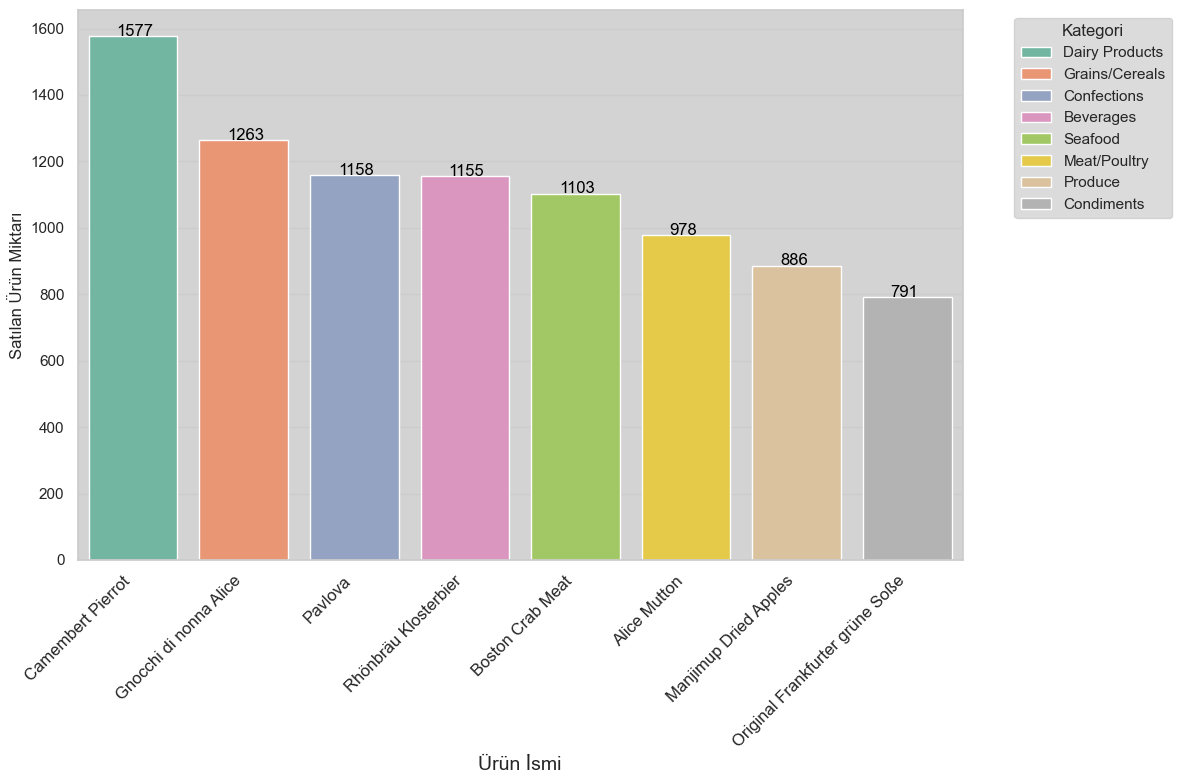

In [22]:
sns.set(style="whitegrid", rc={"axes.facecolor": "#D3D3D3"}) 
plt.figure(figsize=(12, 8))

bar_plot = sns.barplot(
    x="product_name", 
    y="total_quantity_sold",
    hue="category_name",  
    data=df, 
    dodge=False,
    palette="Set2")

bars = bar_plot.patches
for bar, value in zip(bars, df['total_quantity_sold']):  
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.15,  
             bar.get_height() + 1,  
             f'{str(value)}',  
             fontsize=12, color='black')  

plt.xticks(rotation=45, ha="right", fontsize=12)
plt.xlabel("Ürün İsmi", fontsize=14)
plt.ylabel("Satılan Ürün Miktarı", fontsize=12)


handles, labels = bar_plot.get_legend_handles_labels()
plt.legend(handles=handles, labels=labels, bbox_to_anchor=(1.05, 1), loc="upper left", title="Kategori")

plt.tight_layout()
plt.show()


**Görselleştirme sonucunda her kategoride en çok satan ürünü ve satış miktarını göstermektedir. Bu bilgiler doğrultusunda, satış ekibi hangi kategorilerde ve ürünlerde daha fazla talep olduğunu anlamasına yardımcı olacaktır. Örneğin, "Dairy Products" kategorisinde Camembert Pierrot peyniri, "Grains/Cereals" kategorisinde Gnocchi di nonna Alice makarnası ve "Seafood" kategorisinde Boston Crab Meat en çok satan ürünlerdir.Bu ürünlerin stoklarını artırmak veya fiyatlarını ayarlamak, şirketin karlılığını artırabilir. Ayrıca, daha az satan kategorilerde ve bu ürünlerde pazarlama stratejilerini gözden geçirmek, dijital pazarlamayı artırmak (sosyal medya, içerik pazarlama, web sitesi ve uygulama güncellemesi), ürünlerin geri bildirimlerini dikkate alarak iyileştirmeler yapmak veya yeni ürünler sunmak da mümkündür. Bu tür stratejiler, satış performansını iyileştirmek ve müşteri talebini artırmak için etkili olabilir.**

# 2- MÜŞTERİ SADAKAT ANALİZİ  (PostgreSQL - PYTHON)
**Satış Ekibi Müşterilerini Detaylı İncelemek İstiyor.**

# Onlara yardımcı olmak için sizden aşağıdaki bilgileri istediler.
**-En çok adette sipariş veren Müşteriler.
-En çok para harcayan müşteriler.**

In [27]:
sql1 = """SELECT 
    c.customer_id,
    c.company_name,
    COUNT(o.order_id) AS total_orders,
    SUM(od.unit_price * od.quantity * (1 - od.discount)) AS total_spent
FROM customers c
JOIN orders o ON c.customer_id = o.customer_id
JOIN order_details od ON o.order_id = od.order_id
GROUP BY c.customer_id, c.company_name
ORDER BY total_spent DESC
LIMIT 10 """


In [29]:
df = sqlio.read_sql_query(sql1,connection)
df.head()

,customer_id,company_name,total_orders,total_spent
0,QUICK,QUICK-Stop,86,110277.305030
1,ERNSH,Ernst Handel,102,104874.978144
2,SAVEA,Save-a-lot Markets,116,104361.949540
3,RATTC,Rattlesnake Canyon Grocery,71,51097.800828
4,HUNGO,Hungry Owl All-Night Grocers,55,49979.905081


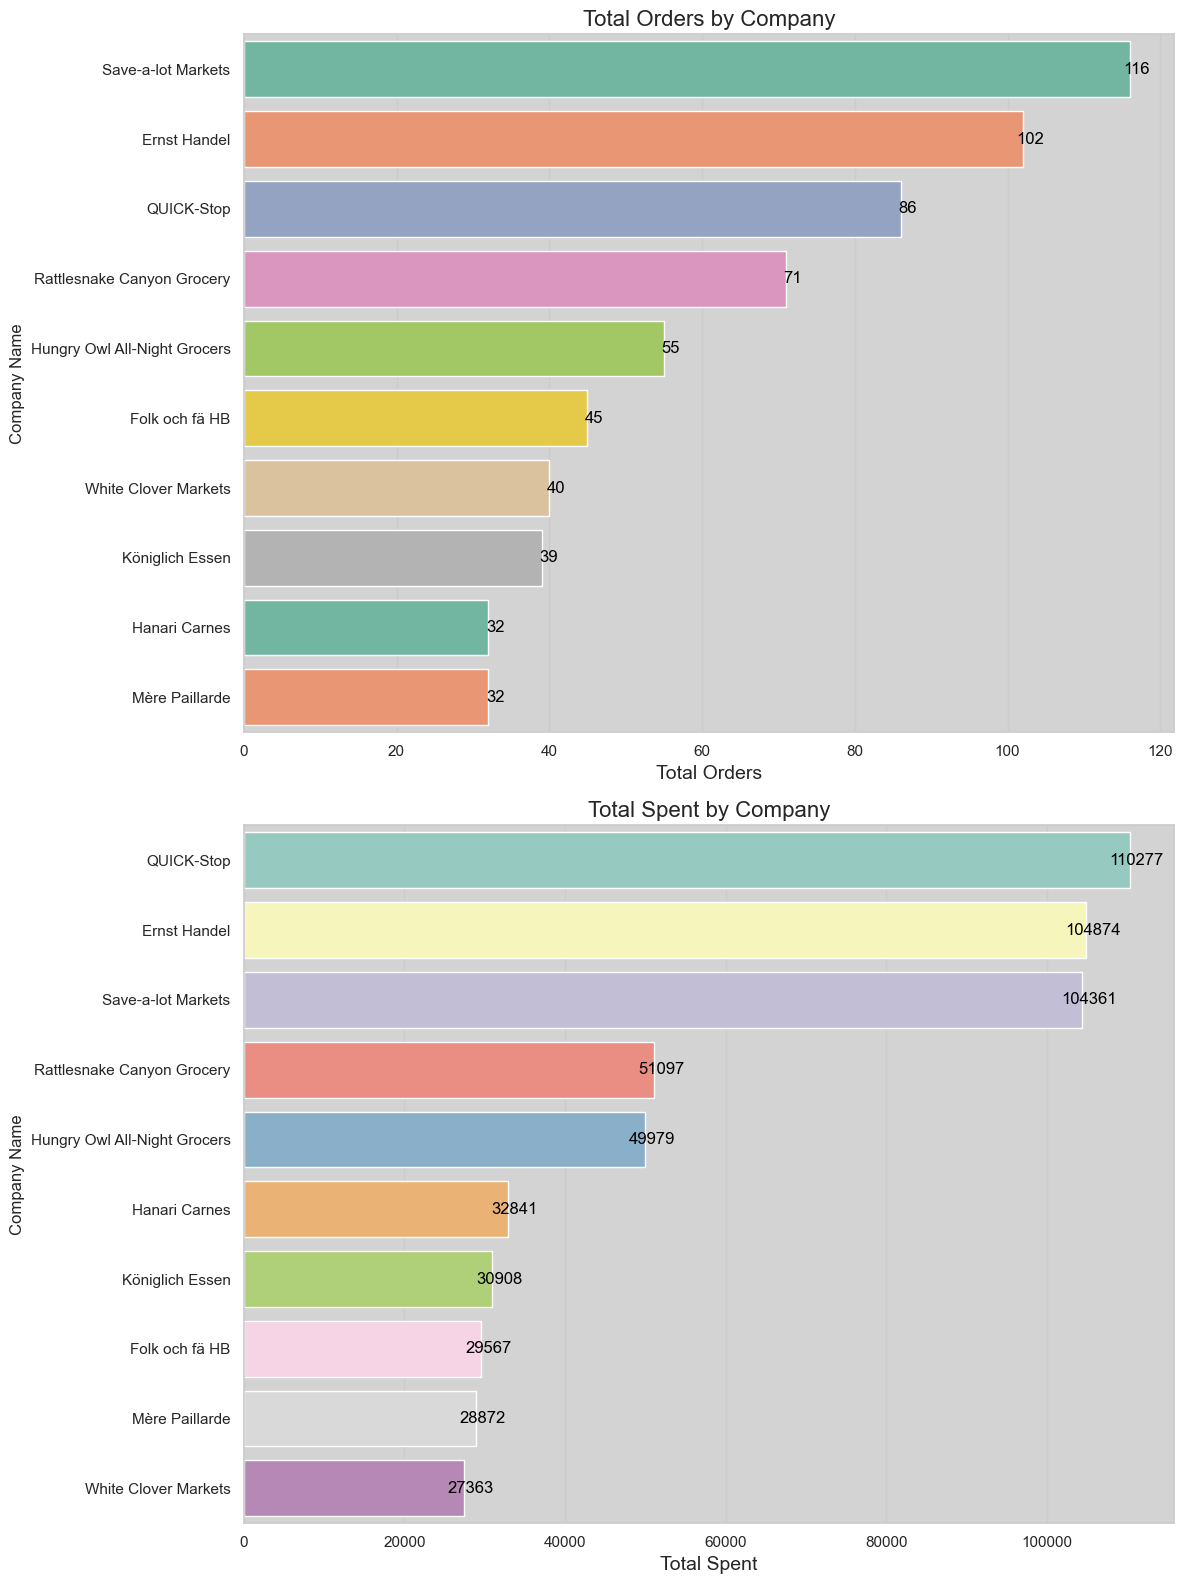

In [31]:
# Total Orders ve Total Spent verilerine göre sıralama
df_sorted_orders = df.sort_values(by="total_orders", ascending=False)
df_sorted_spent = df.sort_values(by="total_spent", ascending=False)

# Grafik stilini ayarlama
sns.set(style="whitegrid", rc={"axes.facecolor": "#D3D3D3"}) 
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))  # Alt alta iki grafik

# 1. Bar Grafiği (Total Orders) - Yatay Bar Grafiği
bar_plot1 = sns.barplot(
    y="company_name", 
    x="total_orders",  
    data=df_sorted_orders,  # Sıralanmış veri
    palette="Set2", 
    ax=ax1)

# Barların üzerine değerleri yazdırma
for bar, value in zip(bar_plot1.patches, df_sorted_orders['total_orders']):
    bar_plot1.annotate(f'{int(value)}', 
                       (bar.get_width(), bar.get_y() + bar.get_height() / 2), 
                       ha='center', va='center', fontsize=12, color='black', 
                       xytext=(5, 0), textcoords='offset points')

bar_plot1.set_xlabel("Total Orders", fontsize=14)
bar_plot1.set_ylabel("Company Name", fontsize=12)
bar_plot1.set_title("Total Orders by Company", fontsize=16)

# 2. Bar Grafiği (Total Spent) - Yatay Bar Grafiği
bar_plot2 = sns.barplot(
    y="company_name", 
    x="total_spent",  
    data=df_sorted_spent,  # Sıralanmış veri
    palette="Set3", 
    ax=ax2)

# Barların üzerine değerleri yazdırma
for bar, value in zip(bar_plot2.patches, df_sorted_spent['total_spent']):
    bar_plot2.annotate(f'{int(value)}', 
                       (bar.get_width(), bar.get_y() + bar.get_height() / 2), 
                       ha='center', va='center', fontsize=12, color='black', 
                       xytext=(5, 0), textcoords='offset points')

bar_plot2.set_xlabel("Total Spent", fontsize=14)
bar_plot2.set_ylabel("Company Name", fontsize=12)
bar_plot2.set_title("Total Spent by Company", fontsize=16)

# Grafikleri yerleştir ve göster
plt.tight_layout()
plt.show()


# Analiz Sonuçları:

**Toplam Sipariş Sayısına Göre Şirketler: İlk grafikte, her bir müşterinin verdiği toplam sipariş sayısı büyükten küçüğe sıralanmıştır. Bu grafikte görülen sipariş sayıları, müşterilerin şirket ile ne kadar sık etkileşimde bulunduğunu göstermektedir. Özellikle sipariş sayısı yüksek olan müşteriler, işletme için kritik öneme sahip olabilir ve bu müşterilere yönelik özel kampanyalar veya hizmetler sunulabilir.**

**Toplam Harcamalara Göre Şirketler: İkinci grafikte, müşterilerin toplam harcamalarına göre sıralanmış durumdadır. Toplam harcama tutarına göre en yüksek harcama yapan müşteriler, işletmenin gelir kaynağı açısından en önemli müşteri gruplarını temsil eder. Bu veriler, müşteri segmentasyonu ve hedefli pazarlama stratejileri geliştirmek için kullanılabilir.**

# Sonuç ve Öneriler:

**Toplam sipariş sayısı ve toplam harcamalar birlikte değerlendirildiğinde, hem sadık hem de yüksek harcama yapan müşterileri belirlemek mümkündür.
İşletme, yüksek harcama yapan müşterilere yönelik sadakat programları veya premium hizmetler sunabilir.
Sipariş sayısı düşük, ancak harcama miktarı yüksek olan müşterilere yönelik stratejilerle müşteri memnuniyeti artırılabilir ve bu müşterilerin daha sık alışveriş yapması sağlanabilir.**